# Node representation learning with Deep Graph Infomax


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/embeddings/deep-graph-infomax-embeddings.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/deep-graph-infomax-embeddings.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

This demo demonstrates how to perform unsupervised training of a GCN, GAT, APPNP, or GraphSAGE model using the Deep Graph Infomax algorithm (https://arxiv.org/pdf/1809.10341.pdf) on the CORA dataset. 

As with all StellarGraph workflows: first we load the dataset, next we create our data generators, and then we train our model. We then take the embeddings created through unsupervised training and predict the node classes using logistic regression.

In [1]:
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
)
from stellargraph import StellarGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE

from stellargraph import datasets
from stellargraph.utils import plot_history

import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from IPython.display import display, HTML

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model
if tf.test.gpu_device_name():
  print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

Default GPU Device:/device:GPU:0


(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [2]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [3]:
G.nodes()

Int64Index([  31336, 1061127, 1106406,   13195,   37879, 1126012, 1107140,
            1102850,   31349, 1106418,
            ...
             626531, 1131180, 1130454, 1131184, 1128974, 1128975, 1128977,
            1128978,  117328,   24043],
           dtype='int64', length=2708)

## Data Generators

Now we create the data generators using `CorruptedGenerator`. `CorruptedGenerator` returns shuffled node features along with the regular node features and we train our model to discriminate between the two. 

Note that:

- We typically pass all nodes to `corrupted_generator.flow` because this is an unsupervised task
- We don't pass `targets` to `corrupted_generator.flow` because these are binary labels (true nodes, false nodes) that are created by `CorruptedGenerator`

In [4]:
# HinSAGE model 
hinsage_generator = HinSAGENodeGenerator(
    G, batch_size=1000, num_samples=[5], head_node_type="paper"
)

hinsage_model = HinSAGE(
    layer_sizes=[128], activations=["relu"], generator=hinsage_generator
)
# hinsage_acc = run_deep_graph_infomax(hinsage_model, hinsage_generator, epochs=epochs)

# print(f"Test classification accuracy: {hinsage_acc}")

corrupted_generator = CorruptedGenerator(hinsage_generator)
gen = corrupted_generator.flow(G.nodes())

## Model Creation and Training

We create and train our `DeepGraphInfomax` model. Note that the loss used here must always be `tf.nn.sigmoid_cross_entropy_with_logits`.

In [5]:
infomax = DeepGraphInfomax(hinsage_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))

In [6]:
epochs = 100

In [7]:
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
history = model.fit(gen, epochs=epochs, verbose=1, callbacks=[es])


  ...
    to  
  ['...']
Train for 3 steps
Epoch 1/100
3/3 [==============================] - 1s 316ms/step - loss: 0.6725
Epoch 2/100
3/3 [==============================] - 0s 45ms/step - loss: 0.6057
Epoch 3/100
3/3 [==============================] - 0s 46ms/step - loss: 0.5559
Epoch 4/100
3/3 [==============================] - 0s 47ms/step - loss: 0.5014
Epoch 5/100
3/3 [==============================] - 0s 47ms/step - loss: 0.4489
Epoch 6/100
3/3 [==============================] - 0s 46ms/step - loss: 0.3992
Epoch 7/100
3/3 [==============================] - 0s 46ms/step - loss: 0.3508
Epoch 8/100
3/3 [==============================] - 0s 46ms/step - loss: 0.3092
Epoch 9/100
3/3 [==============================] - 0s 46ms/step - loss: 0.2687
Epoch 10/100
3/3 [==============================] - 0s 45ms/step - loss: 0.2399
Epoch 11/100
3/3 [==============================] - 0s 46ms/step - loss: 0.2138
Epoch 12/100
3/3 [==============================] - 0s 47ms/step - loss: 0.1853
Epoch

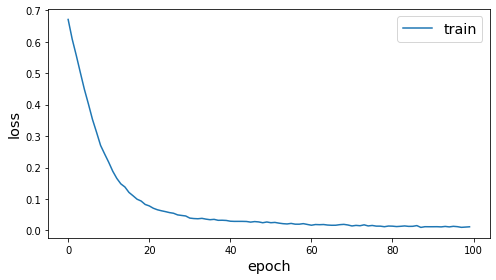

In [8]:
plot_history(history)

## Extracting Embeddings and Logistic Regression

Since we've already trained the weights of our base model - HinSAGE in this example - we can simply use `base_model.in_out_tensors` to obtain the trained node embedding model. Then we use logistic regression on the node embeddings to predict which class the node belongs to.

Note that the results here differ from the paper due to different train/test/val splits.

In [12]:
x_emb_in, x_emb_out = hinsage_model.in_out_tensors()

# for full batch models, squeeze out the batch dim (which is 1)
# x_out = tf.squeeze(x_emb_out, axis=0)
# emb_model = Model(inputs=x_emb_in, outputs=x_out)

# not using full batch models
emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)

In [13]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.1, test_size=None, stratify=node_subjects
)

test_gen = hinsage_generator.flow(test_subjects.index)
train_gen = hinsage_generator.flow(train_subjects.index)

test_embeddings = emb_model.predict(test_gen)
train_embeddings = emb_model.predict(train_gen)

lr = LogisticRegression(multi_class="auto", solver="lbfgs")
lr.fit(train_embeddings, train_subjects)

y_pred = lr.predict(test_embeddings)
hinsage_acc = (y_pred == test_subjects).mean()
print(f"Test classification accuracy: {hinsage_acc}")

Test classification accuracy: 0.7329778506972928


This accuracy is close to that for [training a supervised GCN model end-to-end](../node-classification/gcn-node-classification.ipynb), suggesting that Deep Graph Infomax is an effective method for unsupervised training.

## Visualisation with TSNE

Here we visualize the node embeddings with TSNE. As you can see below, the Deep Graph Infomax model produces well separated embeddings using unsupervised training.

In [16]:
all_embeddings = emb_model.predict(hinsage_generator.flow(G.nodes()))

y = node_subjects.astype("category")
trans = TSNE(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=G.nodes())
emb_transformed["label"] = y

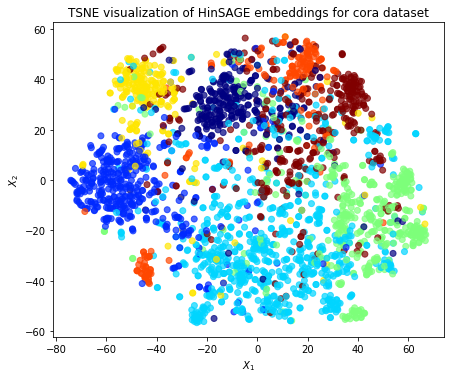

In [17]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].cat.codes,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title("TSNE visualization of HinSAGE embeddings for cora dataset")
plt.show()

## Comparing Different Models

Now we run Deep Graph Infomax training for GAT, GCN, APPNP, and GraphSAGE. Note that switching between StellarGraph models only requires a few code changes.

In [ ]:
def run_deep_graph_infomax(base_model, generator, epochs):
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes())
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    # for full batch models, squeeze out the batch dim (which is 1)
    if isinstance(base_model, (GAT, GCN, APPNP)):
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)

    test_gen = generator.flow(test_subjects.index)
    train_gen = generator.flow(train_subjects.index)

    test_embeddings = emb_model.predict(test_gen)
    train_embeddings = emb_model.predict(train_gen)

    lr = LogisticRegression(multi_class="auto", solver="lbfgs")
    lr.fit(train_embeddings, train_subjects)

    y_pred = lr.predict(test_embeddings)
    acc = (y_pred == test_subjects).mean()

    return acc

In [ ]:
gat_model = GAT(
    layer_sizes=[128], activations=["relu"], generator=fullbatch_generator, attn_heads=8,
)
gat_acc = run_deep_graph_infomax(gat_model, fullbatch_generator, epochs=epochs)

gat_acc
print(f"Test classification accuracy: {gat_acc}")

  ['...']
Test classification accuracy: 0.448318293683347


In [ ]:
appnp_model = APPNP(
    layer_sizes=[128], activations=["relu"], generator=fullbatch_generator
)
appnp_acc = run_deep_graph_infomax(appnp_model, fullbatch_generator, epochs=epochs)

print(f"Test classification accuracy: {appnp_acc}")

  ['...']
Test classification accuracy: 0.4470877768662838


In [ ]:
graphsage_generator = GraphSAGENodeGenerator(G, batch_size=1000, num_samples=[5])

graphsage_model = GraphSAGE(
    layer_sizes=[128], activations=["relu"], generator=graphsage_generator
)
graphsage_acc = run_deep_graph_infomax(
    graphsage_model, graphsage_generator, epochs=epochs
)

print(f"Test classification accuracy: {graphsage_acc}")

  ['...']
Test classification accuracy: 0.7013945857260049


### Heteogeneous models

Cora is a homogeneous graph, with only one type of node (`paper`) and one type of edge (`type`). Models designed for heterogeneous graphs (with moer than one of either) can also be applied to homogeneous graphs, but it is not using their additional flexibility.

HinSAGE is a generalisation of GraphSAGE to heterogeneous graphs that can be trained with Deep Graph Infomax. For homogeneous graphs, it is equivalent to GraphSAGE and it indeed gives similar results.

In [ ]:
hinsage_generator = HinSAGENodeGenerator(
    G, batch_size=1000, num_samples=[5], head_node_type="paper"
)

hinsage_model = HinSAGE(
    layer_sizes=[128], activations=["relu"], generator=hinsage_generator
)
hinsage_acc = run_deep_graph_infomax(hinsage_model, hinsage_generator, epochs=epochs)

print(f"Test classification accuracy: {hinsage_acc}")

  ['...']
Test classification accuracy: 0.7038556193601313


### Overall results

The cell below shows the accuracy of each model.

In [ ]:
pd.DataFrame(
    [gat_acc, gcn_acc, appnp_acc, graphsage_acc, hinsage_acc],
    index=["GAT", "GCN", "APPNP", "GraphSAGE", "HinSAGE"],
    columns=["Accuracy"],
)

,Accuracy
GAT,0.448318
GCN,0.798195
APPNP,0.447088
GraphSAGE,0.701395
HinSAGE,0.703856


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/embeddings/deep-graph-infomax-embeddings.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/deep-graph-infomax-embeddings.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>